In [1]:
# Shrirang Alias Samarth Patil
# 19BAI10079
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
%matplotlib inline

In [2]:
emails = pd.read_csv('../input/emails.csv')

In [3]:
emails.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
#Lets read a single email 

emails.get_value(58,'text')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


'Subject: did you complete this ?  free service  mortgage rates have never been lower .  is your credit good ? get a loan beyond your wildest  expectations !  click here  your credit stinks ? lenders  will still give you an absolutely amazing loan .  click here  just click here and get started .  absolutely free quote .  click  here for quick details ! '

In [5]:
emails.shape
#Total 5728 emails

(5728, 2)

In [6]:
#Checking class distribution
emails.groupby('spam').count()
#23.88% emails are spam which seems good enough for our task

,text
spam,
0,4360
1,1368


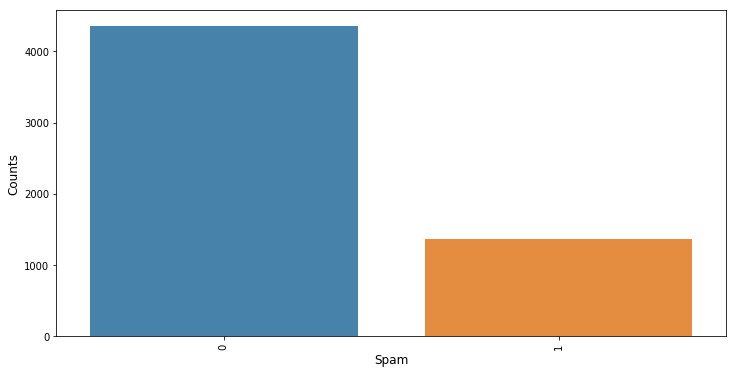

In [7]:
#Lets see the distribution of spam using beautiful seaborn package

label_counts = emails.spam.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('Spam', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

In [8]:
#Lets check if email length is coorelated to spam/ham
emails['length'] = emails['text'].map(lambda text: len(text))

emails.groupby('spam').length.describe()

,count,mean,std,min,25%,50%,75%,max
spam,,,,,,,,
0,4360.0,1631.918119,1959.664549,13.0,577.75,1122.0,2037.25,43952.0
1,1368.0,1317.257310,2271.372893,18.0,401.50,693.5,1250.25,28432.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f15330f9518>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f1532f88710>], dtype=object)

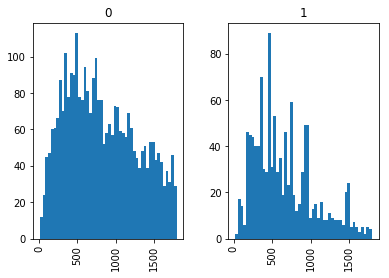

In [9]:
#emails length have some extreme outliers, lets set a length threshold & check length distribution
emails_subset = emails[emails.length < 1800]
emails_subset.hist(column='length', by='spam', bins=50)

#Nothing much here, lets process the contents of mail now for building spam filter

In [10]:
emails['tokens'] = emails['text'].map(lambda text:  nltk.tokenize.word_tokenize(text)) 

In [11]:
#Lets check tokenized text from first email

print(emails['tokens'][1])

['Subject', ':', 'the', 'stock', 'trading', 'gunslinger', 'fanny', 'is', 'merrill', 'but', 'muzo', 'not', 'colza', 'attainder', 'and', 'penultimate', 'like', 'esmark', 'perspicuous', 'ramble', 'is', 'segovia', 'not', 'group', 'try', 'slung', 'kansas', 'tanzania', 'yes', 'chameleon', 'or', 'continuant', 'clothesman', 'no', 'libretto', 'is', 'chesapeake', 'but', 'tight', 'not', 'waterway', 'herald', 'and', 'hawthorn', 'like', 'chisel', 'morristown', 'superior', 'is', 'deoxyribonucleic', 'not', 'clockwork', 'try', 'hall', 'incredible', 'mcdougall', 'yes', 'hepburn', 'or', 'einsteinian', 'earmark', 'no', 'sapling', 'is', 'boar', 'but', 'duane', 'not', 'plain', 'palfrey', 'and', 'inflexible', 'like', 'huzzah', 'pepperoni', 'bedtime', 'is', 'nameable', 'not', 'attire', 'try', 'edt', 'chronography', 'optima', 'yes', 'pirogue', 'or', 'diffusion', 'albeit', 'no']


In [12]:
#Removing stop words

stop_words = set(nltk.corpus.stopwords.words('english'))
emails['filtered_text'] = emails['tokens'].map(lambda tokens: [w for w in tokens if not w in stop_words]) 

In [13]:
#Every mail starts with 'Subject :' lets remove this from each mail 

emails['filtered_text'] = emails['filtered_text'].map(lambda text: text[2:])

In [14]:
#Lets compare an email with stop words removed

print(emails['tokens'][3],end='\n\n')
print(emails['filtered_text'][3])

#many stop words like 'the', 'of' etc. were removed

['Subject', ':', '4', 'color', 'printing', 'special', 'request', 'additional', 'information', 'now', '!', 'click', 'here', 'click', 'here', 'for', 'a', 'printable', 'version', 'of', 'our', 'order', 'form', '(', 'pdf', 'format', ')', 'phone', ':', '(', '626', ')', '338', '-', '8090', 'fax', ':', '(', '626', ')', '338', '-', '8102', 'e', '-', 'mail', ':', 'ramsey', '@', 'goldengraphix', '.', 'com', 'request', 'additional', 'information', 'now', '!', 'click', 'here', 'click', 'here', 'for', 'a', 'printable', 'version', 'of', 'our', 'order', 'form', '(', 'pdf', 'format', ')', 'golden', 'graphix', '&', 'printing', '5110', 'azusa', 'canyon', 'rd', '.', 'irwindale', ',', 'ca', '91706', 'this', 'e', '-', 'mail', 'message', 'is', 'an', 'advertisement', 'and', '/', 'or', 'solicitation', '.']

['4', 'color', 'printing', 'special', 'request', 'additional', 'information', '!', 'click', 'click', 'printable', 'version', 'order', 'form', '(', 'pdf', 'format', ')', 'phone', ':', '(', '626', ')', '338',

In [15]:
#Mails still have many special charater tokens which may not be relevant for spam filter, lets remove these
#Joining all tokens together in a string
emails['filtered_text'] = emails['filtered_text'].map(lambda text: ' '.join(text))

#removing apecial characters from each mail 
emails['filtered_text'] = emails['filtered_text'].map(lambda text: re.sub('[^A-Za-z0-9]+', ' ', text))

In [16]:
wnl = nltk.WordNetLemmatizer()
emails['filtered_text'] = emails['filtered_text'].map(lambda text: wnl.lemmatize(text))

In [17]:
#Lets check one of the mail again after all these preprocessing steps
emails['filtered_text'][4]

'money get software cds software compatibility great grow old along best yet tradgedies finish death comedies ended marriage '

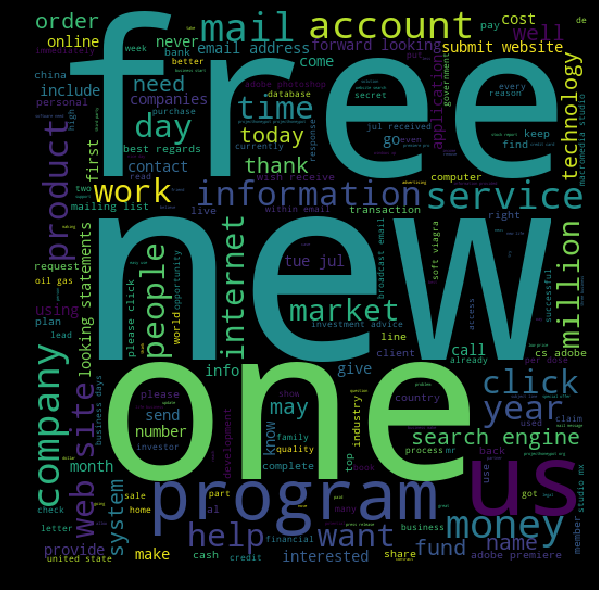

In [18]:
#Wordcloud of spam mails
spam_words = ''.join(list(emails[emails['spam']==1]['filtered_text']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

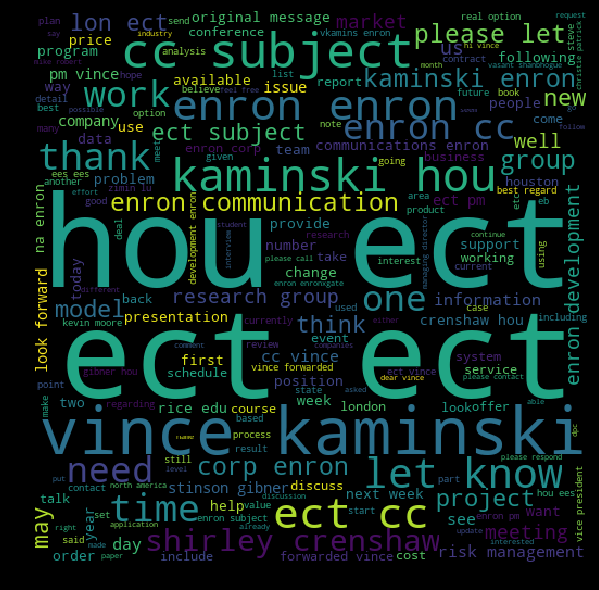

In [19]:
#Wordcloud of non-spam mails
spam_words = ''.join(list(emails[emails['spam']==0]['filtered_text']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [20]:
count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(emails['filtered_text'].values)

In [21]:
print(counts.shape)

(5728, 37158)


In [22]:
classifier = MultinomialNB()
targets = emails['spam'].values
classifier.fit(counts, targets)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [23]:
#Predictions on sample text
examples = ['cheap Viagra', "Forwarding you minutes of meeting"]
example_counts = count_vectorizer.transform(examples)
predictions = classifier.predict(example_counts)

In [24]:
print(predictions)

[1 0]


In [25]:
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf = tfidf_vectorizer.transform(counts)

In [26]:
print(tfidf.shape)

(5728, 37158)


In [27]:
classifier = MultinomialNB()
targets = emails['spam'].values
classifier.fit(counts, targets)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [28]:
#Predictions on sample text
examples = ['Free Offer Buy now',"Lottery from Nigeria","Please send the files"]
example_counts = count_vectorizer.transform(examples)
example_tfidf = tfidf_vectorizer.transform(example_counts)
predictions_tfidf = classifier.predict(example_tfidf)

In [29]:
print(predictions_tfidf)

[1 1 0]
